In [1]:
import shutil
import tempfile

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as date
import seaborn as sns
from scipy import stats
from scipy.signal import kaiserord, filtfilt, firwin
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from sklearn import linear_model
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import BaggingRegressor

sns.set_context('talk')
np.random.seed(1)

Using TensorFlow backend.


In [3]:
data_crime_raw = (pd.read_csv('.\\NYPD_Complaint_Data_Historic.csv',
                             usecols=['CMPLNT_FR_DT', 'LAW_CAT_CD', 'BORO_NM'],
                             dtype={'LAW_CAT_CD':'category', 'BORO_NM':'category'},
                             parse_dates=['CMPLNT_FR_DT'],
                             date_parser=lambda x: pd.to_datetime(x, format='%m/%d/%Y', errors='coerce'))
                  .rename(columns={'CMPLNT_FR_DT': 'date', 'LAW_CAT_CD': 'crime_type', 'BORO_NM': 'borough'}))

In [4]:
data_311_raw = (pd.read_csv('.\\311_Service_Requests_from_2010_to_Present.csv',
                           usecols=['Created Date', 'Complaint Type', 'Borough'],
                           dtype={'Complaint Type':'category', 'Borough':'category',
                                  'Latitude':float, 'Longitude':float},
                           parse_dates=['Created Date'],
                           date_parser=lambda x: pd.to_datetime(x, format='%m/%d/%Y %I:%M:%S %p', errors='coerce'))
                .rename(columns={'Created Date': 'date', 'Complaint Type': '311type', 'Borough': 'borough'}))

In [13]:
data_crime = data_crime_raw[data_crime_raw.date >= pd.to_datetime(dt.date(2010,1,1))].dropna()
data_311 = data_311_raw[data_311_raw.date < pd.to_datetime(dt.date(2016,1,1))].dropna()

data_crime = data_crime[data_crime.crime_type != 'VIOLATION'].drop('crime_type', 1)
data_311 = data_311[data_311.borough != 'Unspecified']
data_311.borough.cat.remove_unused_categories(inplace=True)

In [14]:
boros = data_crime['borough'].cat.categories.tolist()
d_c_boro = {}
d_311_boro = {}
data = {}

for boro in boros:
    d_c_boro[boro] = data_crime[data_crime['borough']==boro].groupby([
        pd.TimeGrouper(key='date', freq='D')]).size()
    d_c_boro[boro].name = 'crime'
    d_311_boro[boro] = data_311[data_311['borough']==boro].groupby([
        pd.TimeGrouper(key='date', freq='D')])['311type'].value_counts().unstack().fillna(0)

In [391]:
thresh = .5
d_311_boro2 = {}

for boro in boros:
    to_del=[]
    for col in d_311_boro[boro].columns.tolist():
        counts = d_311_boro[boro][col].value_counts()
        if 0 in counts.index:
            if counts.loc[0]/len(d_311_boro[boro]) > thresh:
                to_del.append(col)
    d_311_boro2[boro] = d_311_boro[boro].drop(to_del, 1)

In [395]:
#A Kaiser window is used, kaiserord calculates beta parameter for window and optimal number of taps for filter
#Firwin calculates N taps (with N optimally calculated by kaiserord)
#filtfilt convolutes taps forward, and then backward to avoid data lag

nyq_rate = 0.5
width = 0.1/nyq_rate
ripple_db = 1000.0
N, beta = kaiserord(ripple_db, width)

cutoff_hz = (1/10)/nyq_rate

taps = firwin(N, cutoff_hz, window=('kaiser', beta), pass_zero=True)

data_311_filt = {}
data_crime_filt = {}
filt_311 = {}
filt_crime = {}

for boro in boros:
    filt_311[boro] = d_311_boro2[boro].apply(lambda x: filtfilt(taps, 1.0, x))
    filt_crime[boro] = filtfilt(taps, 1.0, d_c_boro[boro])
    data_311_filt[boro] = np.array(d_311_boro2[boro] - filt_311[boro])
    data_crime_filt[boro] = np.array(d_c_boro[boro] - filt_crime[boro])

In [392]:
new_features = {}

ward = FeatureAgglomeration(n_clusters=10)

for boro in boros:
    new_features[boro] = ward.fit_transform(d_311_boro2[boro])

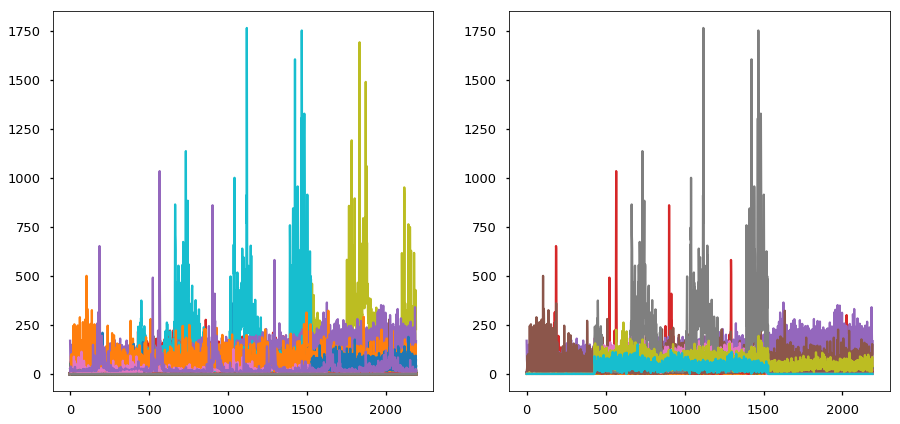

In [393]:
fig, ax = plt.subplots(1, ncols=2, figsize = (15, 7))

for feature in d_311_boro['BRONX'].as_matrix().T:
    ax[0].plot(feature)
    
for feature in new_features['BRONX'].T:
    ax[1].plot(feature)
    
plt.show()

In [171]:
new_featuresdf = {}

for boro in boros:
    new_featuresdf[boro] = pd.DataFrame(new_features[boro], index=d_311_boro[boro].index)

In [172]:
data_merged = {}

for boro in boros:
    data_merged[boro] = new_featuresdf[boro].join(d_c_boro[boro])

In [246]:
# #A Kaiser window is used, kaiserord calculates beta parameter for window and optimal number of taps for filter
# #Firwin calculates N taps (with N optimally calculated by kaiserord)
# #filtfilt convolutes taps forward, and then backward to avoid data lag

# nyq_rate = 0.5
# width = 0.1/nyq_rate
# ripple_db = 1000.0
# N, beta = kaiserord(ripple_db, width)

# cutoff_hz = (1/10)/nyq_rate

# taps = firwin(N, cutoff_hz, window=('kaiser', beta), pass_zero=True)

# data_filt = {}
# filt = {}

# for boro in boros:
#     filt[boro] = data_merged[boro].apply(lambda x: filtfilt(taps, 1.0, x))
#     data_filt[boro] = np.array(data_merged[boro] - filt[boro])

In [260]:
data_scaled = {}
scaler = {}

for boro in boros:
    scaler[boro] = RobustScaler()
    data_scaled[boro] = scaler[boro].fit_transform(data_filt[boro])

In [345]:
lookback = 1
dataX = {}
dataY = {}

for boro in boros:
    tmpx = data_scaled[boro][:,:-1]
    tmpy = data_scaled[boro][:,-1]
    dataX[boro] = []
    dataY[boro] = []
    
    for i in range(len(tmpx)-lookback-1):
        dataX[boro].append(tmpx[i:(i+lookback), :])
        dataY[boro].append(tmpy[i+lookback])
    
    dataX[boro] = np.array(dataX[boro])
    dataX[boro] = np.reshape(dataX[boro], (dataX[boro].shape[0], dataX[boro].shape[1], 10))
    dataY[boro] = np.array(dataY[boro])

In [351]:
batch_size=1
X = dataX['BRONX']
Y = dataY['BRONX']

model = Sequential()
model.add(LSTM(64, batch_input_shape=(batch_size, lookback, 10), stateful=True, return_sequences=True, dropout=0.4))
model.add(LSTM(32, batch_input_shape=(batch_size, lookback, 10), stateful=True, dropout=0.4))
model.add(Dense(1))

# adam = optimizers.Adam(lr=0.01)

model.compile(loss='mean_squared_error', optimizer='rmsprop')
for i in range(10):
    print(f'Epoch {i+1}.')
    model.fit(X, Y, epochs=1, batch_size=batch_size, 
              verbose=2, shuffle=False, validation_split=.2)
    model.reset_states()

Epoch 1.
Train on 1751 samples, validate on 438 samples
Epoch 1/1
17s - loss: 0.5293 - val_loss: 0.4084
Epoch 2.
Train on 1751 samples, validate on 438 samples
Epoch 1/1
15s - loss: 0.4609 - val_loss: 0.4147
Epoch 3.
Train on 1751 samples, validate on 438 samples
Epoch 1/1
15s - loss: 0.4419 - val_loss: 0.4112
Epoch 4.
Train on 1751 samples, validate on 438 samples
Epoch 1/1
15s - loss: 0.4432 - val_loss: 0.4126
Epoch 5.
Train on 1751 samples, validate on 438 samples
Epoch 1/1
16s - loss: 0.4268 - val_loss: 0.4099
Epoch 6.
Train on 1751 samples, validate on 438 samples
Epoch 1/1
16s - loss: 0.4272 - val_loss: 0.4079
Epoch 7.
Train on 1751 samples, validate on 438 samples
Epoch 1/1
16s - loss: 0.4297 - val_loss: 0.4092
Epoch 8.
Train on 1751 samples, validate on 438 samples
Epoch 1/1
16s - loss: 0.4335 - val_loss: 0.4103
Epoch 9.
Train on 1751 samples, validate on 438 samples
Epoch 1/1
17s - loss: 0.4293 - val_loss: 0.4095
Epoch 10.
Train on 1751 samples, validate on 438 samples
Epoch 1

In [352]:
predY = model.predict(dataX['BRONX'], batch_size=1)

In [353]:
lastY = len(predY)+lookback-1

true_data = data_filt['BRONX'][lookback:lastY, -1]
pred_data = np.append(data_scaled['BRONX'][lookback:lastY,:-1], np.reshape(predY[:-1], (predY[:-1].shape[0], 1)), axis=1)

In [354]:
predY2 = scaler['BRONX'].inverse_transform(pred_data)[:, -1]

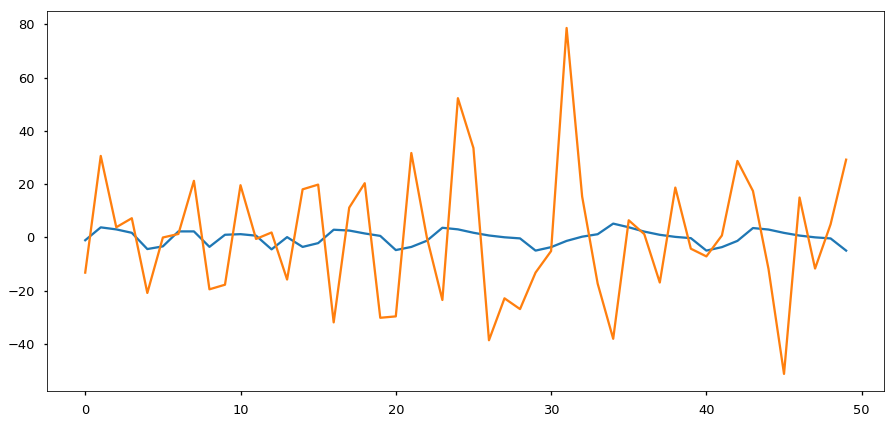

In [355]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(predY2[-50:])
plt.plot(true_data[-50:])
plt.show()

In [380]:
regr = {}
regr_base = {}
X_test = {}
Y_test = {}
split_ind = {}

for i, boro in enumerate(boros):
    split_ind[boro] = int(len(data_scaled[boro]) * .7)
    # Split the data into training/testing sets
    X_train = data_scaled[boro][:split_ind[boro], :-1]
    X_test[boro] = data_scaled[boro][split_ind[boro]:, :-1]
    
    Y_train = data_scaled[boro][:split_ind[boro], -1]
    Y_test[boro] = data_scaled[boro][split_ind[boro]:, -1]

    # Create linear regression object
    regr_base[boro] = linear_model.LinearRegression()
    regr[boro] = BaggingRegressor(base_estimator=regr_base[boro],
                                  n_estimators=1000,
                                  max_samples=0.1,
                                  max_features=0.5,
                                  warm_start=False)

    # Train the model using the training sets
    regr[boro].fit(X_train, Y_train)

In [381]:
predY = regr['BRONX'].predict(X_test['BRONX'])

In [382]:
test_data = np.append(X_test['BRONX'], np.reshape(Y_test['BRONX'], (Y_test['BRONX'].shape[0], 1)), axis=1)
pred_data = np.append(X_test['BRONX'], np.reshape(predY, (predY.shape[0], 1)), axis=1)

In [383]:
test_data2 = scaler['BRONX'].inverse_transform(test_data)
pred_data2 = scaler['BRONX'].inverse_transform(pred_data)

In [384]:
test_data3 = test_data2 + filt['BRONX'][split_ind['BRONX']:]
pred_data3 = pred_data2 + filt['BRONX'][split_ind['BRONX']:]

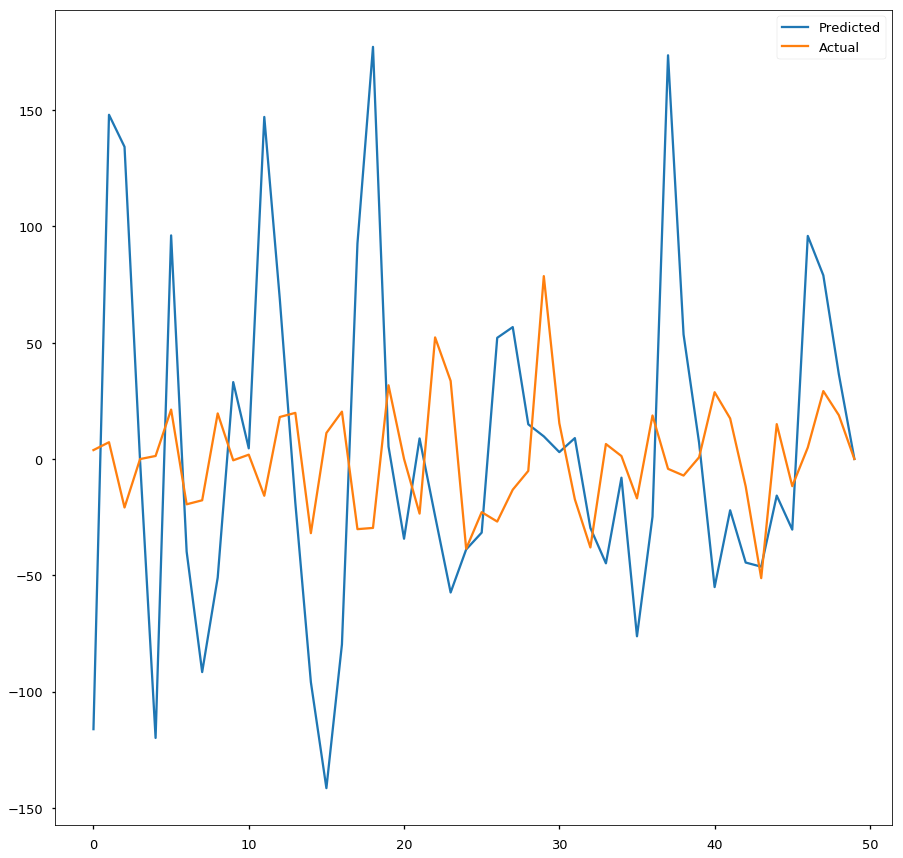

In [385]:
fig, ax = plt.subplots(figsize=(15, 15))
to_plot=50

ax.plot(pred_data2[:, -1][-to_plot:], label='Predicted')
ax.plot(range(len(test_data2[-to_plot:])), test_data2[:, -1][-to_plot:], label='Actual')
ax.legend()
plt.show()